<a href="https://colab.research.google.com/github/jsvir/idc/blob/main/idc_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpretable Deep Clustering (for Tabular Data)

You can use **any** data, also images, but for now the model supports only samples similar to table rows: each sample should be a d-dimensional vector.
The main goal of our method is to discover clusters assignments for the dataset samples and provide **local** (sample-level) and **global** (cluster-level) interpretations. The interpretations are the feature ids that are have the most important information for clustering and are potentially not representing the data noise.

## Model Description:

<img src="https://github.com/jsvir/idc/tree/main/img/img.png" width="500">

We train a Gating Neural Network together with autoencoder with reconstruction objective while our goal to reconstruct the sample x from the gated version of it (x * z). Then we train the clustering head to discover the clustering of the samples. The last stage is to train the auxiliary classifier that trains the global gates matrix for cluster-level features (interpretations). In addition, we add more sub-steps for training that serve as augmentations to the main stages. We add random binary noise to the input samples, we add noise to the latent embeddings (after encoder) and we start train the autoencoder without gating network.

Next, we will go step-by-step with PBMC-2 dataset which is a binary-class subset of the original PBMC [1] dataset. We select two categories that have the most number of samples in the original set. In addition, we remove all zero columns from the data resulting in 17,126 featurees × 20,742 samples size  example to show how the training is done. If you find something unclear, please, let us know.



[1] Zheng, G. X., Terry, J. M., Belgrader, P., Ryvkin, P., Bent, Z. W., Wilson, R., Ziraldo, S. B., Wheeler, T. D., McDermott, G. P., Zhu, J., et al. Massively parallel digital transcriptional profiling of single cells. Nature communications, 8(1):14049, 2017.

### Step 0: config file definitions

| Key                                  | Required / Optional | Example Value                   | Description                                                                                                                                                                                                                                                 |
|--------------------------------------|---------------------|---------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| filepath_samples                              | Required            | C:/data/fs/pbmc/pbmc_x.npz      | *Filepath to the npz file with samples table. The table should be of shape [num of samples, num of features]*                                                                                                                                               |
| num_clusters                             | Required            | 2                               | *Expected number of clusters*                                                                                                                                                                                                                               |
| batch_size                           | Required            | 256                             | *Training and evaluation batch size*                                                                                                                                                                                                                        |
| epochs                               | Required            | 200                             | *How many epochs to train the model (total epochs)*                                                                                                                                                                                                         |
| seeds                                | Required            | 1                               | *How many random intializations for model re-training*                                                                                                                                                                                                      |
| ae_non_gated_epochs                  | Required            | 50                              | *Number of epochs for autoencoder pre-training without gating network.*                                                                                                                                                                                     |
| ae_pretrain_epochs                   | Required            | 100                             | *Number of epochs for autoencoder pre-training with gating network.*                                                                                                                                                                                        |
| start_global_gates_training_on_epoch | Required            | 150                             | *After this number of epochs we start to train aux. classifier with global gates.*                                                                                                                                                                          |
| mask_percentage                      | Required            | 0.9                             | *The random subset of features that will be masked by zero gates. The tuning of this parameter should be based on reconstruction loss convergence. For better convergence try smaller values. Far sparse mask try larger*                                   |
| latent_noise_std                     | Required            | 0.01                            | *The std value for random normal noise with mean=1 that multiplies latent embeddings (H) outputed by the encoder.*                                                                                                                                          |
| gtcr_loss                            | Optional            | true                            | *Use it to encourge features uniquness at sample-level (the model will try to find the unique set of features for each sample.*                                                                                                                             |
| gtcr_projection_dim                  | Optional            | 1024                            | *For large number of features (>10K) it will apply a random projection to the smaller dimension which affects only the GTCR loss*                                                                                                                           |
| gtcr_eps                             | Optional            | 1                               | *Code Reduction Rate precision parameter *                                                                                                                                                                                                                  |
| eps                                  | Required            | 0.1                             | *Clustering head loss is trained with code reduction rate -based objective with precision parameter. Notice, that here the loss operates on latent embedding and helps to cluster them while gtcr operates on gates only and try to seperate between them.* |
| use_gating                           | Required            | true                            | *If trained with Gating Network.*                                                                                                                                                                                                                           |
| gates_hidden_dim                     | Required            | 784                             | *The hodden layer dimension in Gating Network.*                                                                                                                                                                                                             |
| encdec                               | Required            | [512,512,2048,128,2048,512,512] | *Autoencoder architecture. Each value represents the hidden layer dimension*                                                                                                                                                                                |
| clustering_head                      | Required            | [128, 2048]                     | *Clustering head dimension. The input dimension and the hidden dimension.*                                                                                                                                                                                  |
| tau                                  | Required            | 100                             | *Tempretaure for GumbleSoftmax. We used a fixed value but you can try also to change it dring the training*                                                                                                                                                 |
| aux_classifier                       | Required            | 2048                            | *TThe dimension of the hidden layer in the aux classifier*                                                                                                                                                                                                  |
| local_gates_lambda                   | Required            | 1                               | *The weight of the sparsity loss term in the total clustering loss computation.*                                                                                                                                                                            |
| global_gates_lambda                  | Required            | 1                               | *The weight of the sparsity loss term in the total aix classifier loss computation.*                                                                                                                                                                        |
| gtcr_lambda                          | Required            | 0.01                            | *The weight of the uniqness loss term in the total clustering loss computation.*                                                                                                                                                                            |
| lr.pretrain                          | Required            | 1e-3                            | *The learning rate for the autoencoder and gating networks.*                                                                                                                                                                                                |
| lr.clustering                        | Required            | 1e-3                            | *The learning rate for the clustering head.*                                                                                                                                                                                                                |
| lr.aux_classifier                    | Required            | 1e-1                            | *The learning rate for the aux classifier and global gates matrix.*                                                                                                                                                                                         |
| sched.pretrain_min_lr                | Required            | 1e-4                            | *The min learning rate for the autoencoder and gating networks.*                                                                                                                                                                                            |
| sched.clustering_min_lr              | Required            | 1e-4                            | *The min learning rate for the clustering head.*                                                                                                                                                                                                            |
| save_seed_checkpoints                | Required            | false                           | *Change it to true if you would like to save the checkpoint.*                                                                                                                                                                                               |

And finally there are some additional pytorch-lightning configs you should provide but it could remain the same valeus as below:

trainer:
  devices: 1
  accelerator: gpu
  max_epochs: *epochs
  deterministic: true
  logger: true
  log_every_n_steps: 10
  check_val_every_n_epoch: 10
  enable_checkpointing: false
  

We clone the repo and print the yaml config file we will use for PBMC:

In [1]:
# !rm -r idc && git clone https://github.com/jsvir/idc.git

rm: cannot remove 'idc': No such file or directory


In [2]:
!git clone https://github.com/jsvir/idc.git

Cloning into 'idc'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 26 (delta 8), reused 23 (delta 7), pack-reused 0
Receiving objects: 100% (26/26), 16.65 MiB | 17.03 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [ ]:
!cd idc && pip install -r requirements.txt

In [4]:
with open("idc/cfg/cfg_run.yaml") as f:
    for line in f.readlines():
        print(line.strip())

filepath_samples: idc/data/pbmc_x.npz
num_clusters: 2

batch_size: 256
seeds: 1
epochs: &epochs 200

ae_non_gated_epochs: 5 #50
ae_pretrain_epochs: 10 #100
start_global_gates_training_on_epoch: 150

mask_percentage: 0.9
latent_noise_std: 0.01

trainer:
devices: 1
accelerator: gpu
max_epochs: *epochs
deterministic: true
logger: true
log_every_n_steps: 10
check_val_every_n_epoch: 10
enable_checkpointing: false
num_sanity_val_steps: 0


# GTCR loss
gtcr_loss: true
gtcr_projection_dim: 1024 # for large number of features use it
gtcr_eps: 1


# Compression loss
eps: 0.1

# Gating Net
use_gating: true
gates_hidden_dim: 1024

# EncoderDecoder
encdec:
- 512
- 512
- 2048
- &bn_layer 128
- 2048
- 512
- 512

clustering_head:
- *bn_layer
- 2048

tau: 100

aux_classifier:
- 2048

local_gates_lambda: 100
global_gates_lambda: 10
gtcr_lambda: 0.01

lr:
pretrain: 1e-3
clustering: 1e-3
aux_classifier: 1e-1

sched:
pretrain_min_lr: 1e-4
clustering_min_lr: 1e-4

save_seed_checkpoints: false


### Step 1: data preparation

We provide the PBMC-2 dataset in the data directory, unzip it:


In [5]:
!unzip idc/data/pbmc_x.zip


Archive:  idc/data/pbmc_x.zip
  inflating: pbmc_x.npz              


### Step 2: run clustering training

We modify the function that plots the clustering to show the plot in the notebook:

In [9]:
import sys
sys.path.append("./idc")
import umap
import matplotlib.pyplot as plt

def plot_clustering(val_embs_list, cluster_mtx, current_epoch, silhouette, dbi):
    reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=0)
    embedding = reducer.fit_transform(torch.cat(val_embs_list, dim=0).cpu().numpy())
    plt.figure(figsize=(5, 3))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_mtx.numpy(), s=20, edgecolor='k')
    plt.title(f'Clustering (UMAP). Epoch: {current_epoch}. Silhouette: {silhouette:0.3f}. DBI: {dbi:0.3f}')
    plt.show()

Now we train the model.
Use these tensorboard commands to show the tensorboard logs in the notebook. Tested on my local machine bit not in Colab.

In [ ]:
# !tensorboard --logdir logs\example --port 6006 &

In [ ]:
# from tensorboard import notebook
# notebook.list() # View open TensorBoard instances
# notebook.display(port=6006, height=1000)

In [7]:
!ls

idc  pbmc_x.npz  sample_data


INFO:lightning_fabric.utilities.seed:Global seed set to 777


X.shape:  (20742, 17126)
X.min=0.0, X.max=173.0
Dataset length: 20742


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                          | Params
----------------------------------------------------------------------
0 | gating_net          | GatingNet                     | 35.1 M
1 | encdec              | EncoderDecoder                | 20.7 M
2 | clustering_head     | Sequential                    | 272 K 
3 | aux_classifier_head | Sequential                    | 35.1 M
4 | mcrr                | MaximalCodingRateReduction    | 0     
5 | gtcr_loss           | TotalCodingRateWithProjection | 0     
-------------------

Cosine annealing LR scheduling is applied during 15390 steps


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


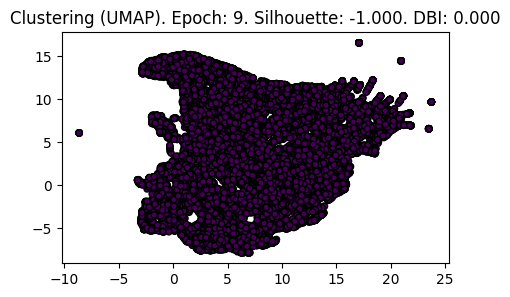

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


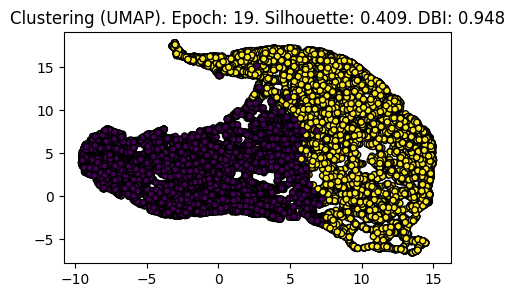

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


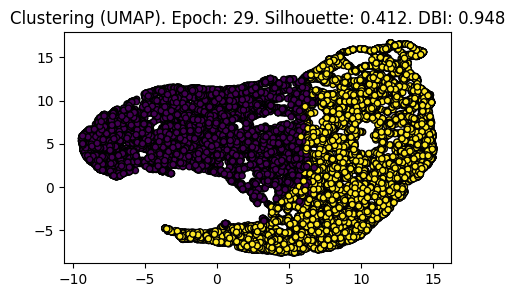

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


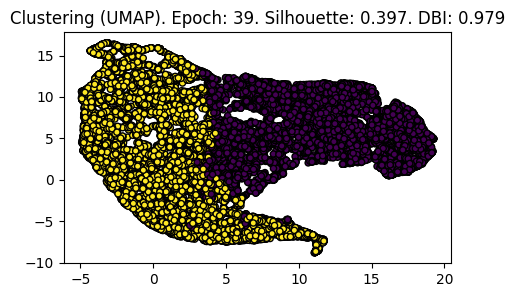

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


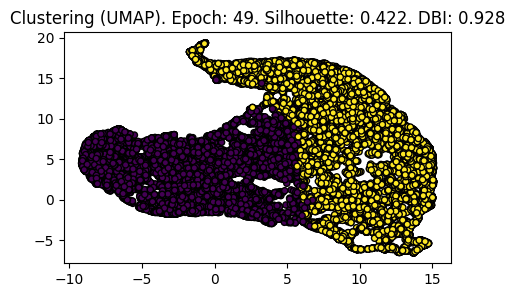

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


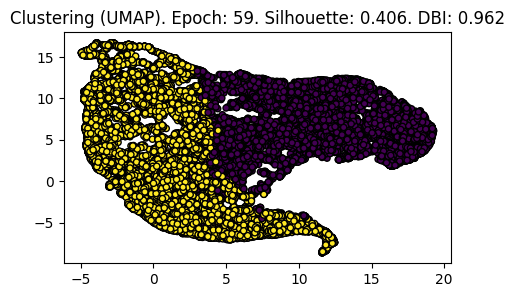

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


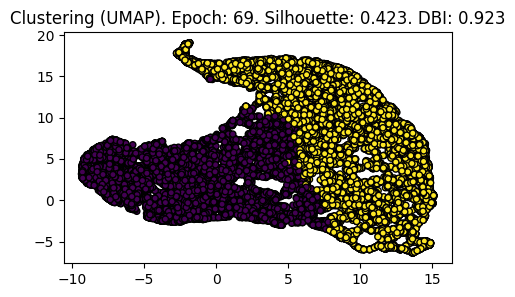

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


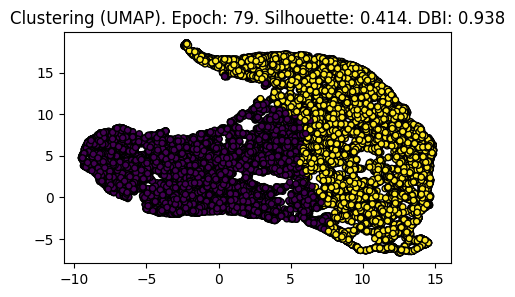

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


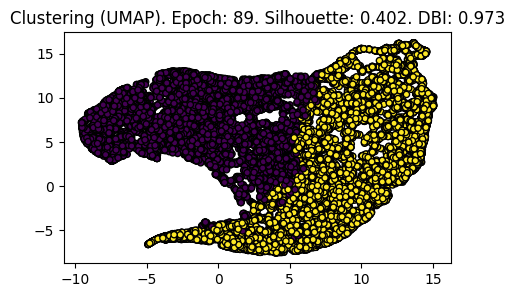

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


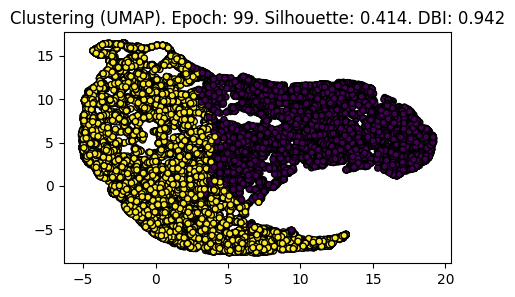

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


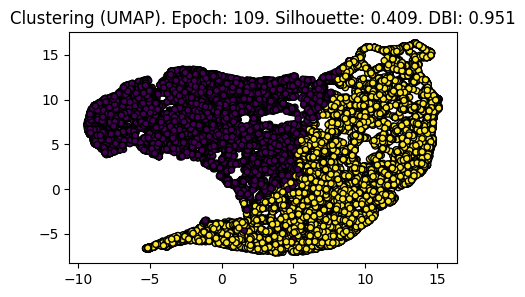

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


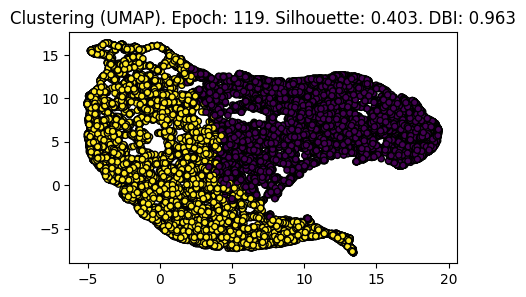

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [10]:
import torch
from omegaconf import OmegaConf
import numpy as np
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from run import BaseModule


cfg = OmegaConf.load("idc/cfg/cfg_run.yaml")
cfg.filepath_samples = "pbmc_x.npz" # due to colab issues
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
seed=777
cfg.seed = seed
seed_everything(seed)
np.random.seed(seed)
model = BaseModule(cfg)
model.plot_clustering = plot_clustering
logger = TensorBoardLogger("logs", name="example", log_graph=False)
trainer = Trainer(**cfg.trainer, callbacks=[LearningRateMonitor(logging_interval='step')])
trainer.logger = logger
trainer.fit(model)